In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

from monotonic import start_pipeline

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## 1. Preprocessing

In [2]:
data = pd.read_excel('data/bank.xlsx')

In [3]:
%%time
data = pd.read_excel('data/bank_null.xlsx')
df_woe_uncorr, corr_matrix, to_drop, iv_values = start_pipeline(data)

Replace on WOE optimal = 0.029 seconds
Creating full stats = 2.093 seconds
Cutting of by IV = 0.001 seconds
Delete correlations = 0.977 seconds
Wall time: 3.7 s


In [4]:
df_woe_uncorr

,WOE_age,WOE_balance,WOE_campaign,WOE_contact,WOE_day,WOE_default,WOE_duration,WOE_education,WOE_housing,WOE_job,WOE_loan,WOE_marital,WOE_month,WOE_poutcome,WOE_previous,target
0,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,-5.525453,0
1,-0.081105,0.240328,0.000250,0.253374,0.039765,-0.000279,0.152049,-0.091389,-0.325551,-0.261647,-0.674385,-0.169300,-0.603057,0.124649,0.944706,0
2,-0.081105,0.240328,0.000250,0.253374,0.039765,-0.000279,-0.934434,0.247403,-0.325551,0.182478,0.090896,0.219950,0.595584,0.124649,-0.189939,0
3,-0.081105,0.240328,0.000250,-0.992066,-0.104812,-0.000279,-0.934434,0.247403,-0.325551,0.182478,-0.674385,-0.169300,-0.119784,-0.263395,-0.189939,0
4,-0.081105,-0.294329,0.000250,-0.992066,-0.104812,-0.000279,0.152049,-0.091389,-0.325551,-0.504098,0.090896,-0.169300,-0.603057,-0.263395,-0.189939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,-0.081105,-0.294329,0.000250,0.253374,0.039765,-0.000279,0.152049,-0.091389,-0.325551,-0.261647,0.090896,-0.169300,-0.320075,-0.263395,-0.189939,0
4517,-0.081105,-0.294329,0.000250,-0.992066,-0.104812,0.030830,-0.934434,0.247403,-0.325551,-0.059717,-0.674385,-0.169300,-0.603057,-0.263395,-0.189939,0
4518,-0.081105,-0.294329,0.000250,0.253374,0.039765,-0.000279,-0.934434,-0.091389,0.330836,-0.072278,0.090896,-0.169300,0.090582,-0.263395,-0.189939,0
4519,-0.081105,0.240328,0.000250,0.253374,-0.104812,-0.000279,-1.807347,-0.091389,0.330836,-0.504098,0.090896,-0.169300,0.460942,0.606970,0.944706,0


## 2. In-Sample and Out-of-Sample split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

In [6]:
X = df_woe_uncorr.drop(columns='target').values
y = df_woe_uncorr['target'].values

In [7]:
for train_index, test_index in sss.split(X, y):
    X_in, X_out = X[train_index], X[test_index]
    y_in, y_out = y[train_index], y[test_index]
    
    print('Share of "good" in Out-of-Sample = {}'.format(np.sum(y_out)/len(y_out)))
    print('Share of "good" in In-Sample     = {}'.format(np.sum(y_in)/len(y_in)))

Share of "good" in Out-of-Sample = 0.11479028697571744
Share of "good" in In-Sample     = 0.11529006882989185


## 3. Train-Valid Split

In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X_in, y_in):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print('Share of "good" in Out-of-Sample = {}'.format(np.sum(y_test)/len(y_test)))
    print('Share of "good" in In-Sample     = {}'.format(np.sum(y_test)/len(y_test)))

Share of "good" in Out-of-Sample = 0.14004914004914004
Share of "good" in In-Sample     = 0.14004914004914004


## 4. Train Model

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    
    plt.figure(figsize=(9,6))
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    
    plt.title('Validation Curves')
    plt.xlabel('C')
    plt.ylabel('ROC AUC score')
    plt.ylim(0.8, 1)
    plt.legend()
    plt.show()

**Rude search**

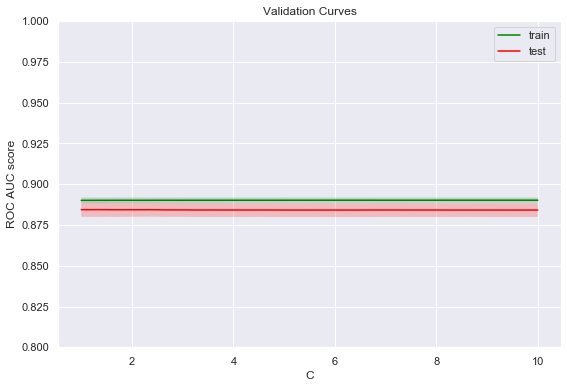

In [10]:
log_reg = LogisticRegression(n_jobs=-1, solver='lbfgs')
param_grid_log = {'C': np.logspace(1e-5, 1)}

grid_search = GridSearchCV(log_reg, param_grid=param_grid_log, scoring='roc_auc',
                           n_jobs=-1, cv=5, return_train_score=True)

grid_search.fit(X_in, y_in)

plot_validation_curves(param_grid_log['C'], grid_search.cv_results_)

#### Hypo-parameter *C* is not sensitive to change

## 5. Model Evaluation

In [11]:
log_reg = LogisticRegression(C=1.0, n_jobs=-1, solver='lbfgs')
log_reg.fit(X_in, y_in)
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = log_reg.predict_proba(X_out)[:,1]
fpr, tpr, thresholds = roc_curve(y_out, y_score)
roc_auc = auc(fpr, tpr)

### ROC-curve

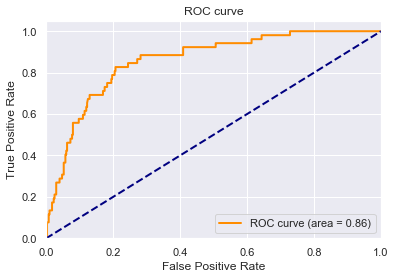

In [12]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### PR-curve

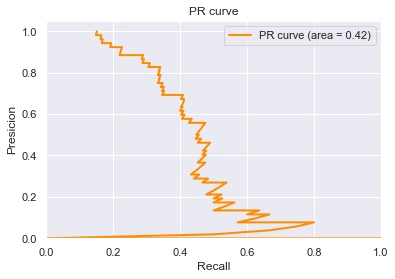

In [13]:
pr, rec, _ = precision_recall_curve(y_out, y_score)

plt.plot(pr, rec, color='darkorange',
         lw=2, label='PR curve (area = %0.2f)' % auc(rec, pr))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Presicion')
plt.title('PR curve')
plt.legend(loc="upper right")
plt.show()

### Gini

In [14]:
print('GINI = {}'.format(2*roc_auc - 1))

GINI = 0.7156627661615191
